## Watch Data

In [2]:
import os
import statistics
import csv
import itertools
import keras
import sklearn.linear_model

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn

from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import *
from keras.utils import to_categorical
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
act_path = "wisdm-dataset/activity_key.txt"
act_file = open(act_path,"r")
act_list = act_file.read().split('\n')
act_map = {}
for elem in act_list:
    split = elem.split(" = ")
    if len(split) < 2:
        continue
    act_map[split[1]] = split[0]
    
act_map

{'A': 'walking',
 'B': 'jogging',
 'C': 'stairs',
 'D': 'sitting',
 'E': 'standing',
 'F': 'typing',
 'G': 'teeth',
 'H': 'soup',
 'I': 'chips',
 'J': 'pasta',
 'K': 'drinking',
 'L': 'sandwich',
 'M': 'kicking',
 'O': 'catch',
 'P': 'dribbling',
 'Q': 'writing',
 'R': 'clapping',
 'S': 'folding'}

In [4]:
watch = pd.read_pickle('watch.df')

In [5]:
window_size = 100 #prev 
stride = window_size

frames = []
for i in tqdm(range(0, len(watch)-window_size, stride)):
    window = watch.iloc[i:i+window_size]
    if window['activity'].nunique() == 1:
        frames.append(window)

In [6]:
activities = sorted(act_map.keys())
activity_encoding = {v: k for k, v in enumerate(activities)}

X_list = []
y_list = []

for frame in tqdm(frames):
    X_list.append(frame[['watch_accel_x', 'watch_accel_y', 'watch_accel_z', 'watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z']].values)
    y_list.append(activity_encoding[frame.iloc[0]['activity']])

In [7]:
X = np.array(X_list)
y = np.array(to_categorical(y_list))

In [8]:
print(X.shape)
print(y.shape)

(36395, 100, 6)
(36395, 18)


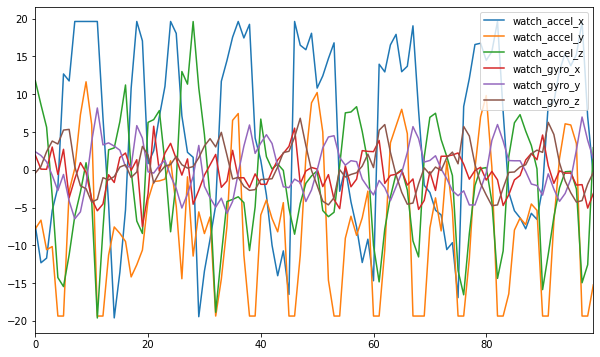

In [9]:
#six datapoints: phone, watch and each has accel and gyros data 
#example: xyz of accel for phone is 0 1 2 
#n is index into the dataframe of the X_list which is list of all of the windows
n = 5000
data_example= pd.DataFrame(X_list[n])

# Reverse activity encoding encodes index like 3 -> eating sandwich
reverse_activity_encoding = {v: act_map[k] for k, v in activity_encoding.items()}

# Change the size of the plot (in inches)
plt.rcParams["figure.figsize"] = (10,6)

axis = data_example.plot()
axis.legend(['watch_accel_x', 'watch_accel_y', 'watch_accel_z', 'watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z'])
plt.show()

In [10]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(21837, 100, 6)
(7279, 100, 6)
(7279, 100, 6)
(21837, 18)
(7279, 18)
(7279, 18)


## LogReg Baseline

In [11]:
# lrModel = sklearn.linear_model.LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
# X_train_flattened = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
# print(X_train_flattened.shape)
# lrModel.fit(X_train_flattened, y_train.argmax(axis=1))

In [12]:
# predictions = lrModel.predict(X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]))
# score = lrModel.score(X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]), y_val.argmax(axis=1))
# print(score)

In [13]:
# cm = confusion_matrix(y_val.argmax(axis=1), predictions)
# df_cm = pd.DataFrame(cm, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
# plt.figure(figsize = (20,20))
# sn.heatmap(df_cm, annot=True, fmt='g')

# Model Architecture

In [43]:
# CNN
# =========
cnn_model = Sequential()

# Added Dropout to reduce overfitting on validation
# cnn_model.add(Dropout(0.2, input_shape=X_train.shape[1:]))

cnn_model.add(Conv1D(8, 3, activation='relu', input_shape=X_train.shape[1:]))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Conv1D(16, 3, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Conv1D(32, 3, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Conv1D(64, 3, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(y_train.shape[1], activation='softmax'))
# =========



In [83]:
# LSTM
# =========
lstm_model = Sequential()

lstm_model.add(LSTM(64, return_sequences=True, input_shape=X_train.shape[1:]))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(y_train.shape[1], activation='softmax'))
# =========

# Training + Evalutating CNN

In [45]:
cnn_model.compile(Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['acc'])

In [46]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = cnn_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=1, callbacks=[es])

cnn_model.summary()

Train on 21837 samples, validate on 7279 samples
Epoch 1/20
21837/21837 [==============================] - 7s 328us/step - loss: 1.5364 - acc: 0.5033 - val_loss: 1.1441 - val_acc: 0.6170
Epoch 2/20
21837/21837 [==============================] - 6s 286us/step - loss: 1.1154 - acc: 0.6293 - val_loss: 1.0064 - val_acc: 0.6574
Epoch 3/20
21837/21837 [==============================] - 6s 285us/step - loss: 0.9654 - acc: 0.6777 - val_loss: 0.9311 - val_acc: 0.6822
Epoch 4/20
21837/21837 [==============================] - 6s 288us/step - loss: 0.8829 - acc: 0.7032 - val_loss: 0.8725 - val_acc: 0.7030
Epoch 5/20
21837/21837 [==============================] - 6s 288us/step - loss: 0.8115 - acc: 0.7210 - val_loss: 0.8458 - val_acc: 0.7192
Epoch 6/20
21837/21837 [==============================] - 6s 288us/step - loss: 0.7518 - acc: 0.7402 - val_loss: 0.8417 - val_acc: 0.7229
Epoch 7/20
21837/21837 [==============================] - 6s 294us/step - loss: 0.7037 - acc: 0.7579 - val_loss: 0.8144 - v

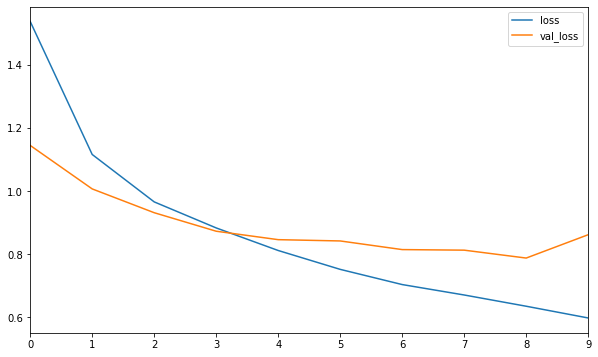

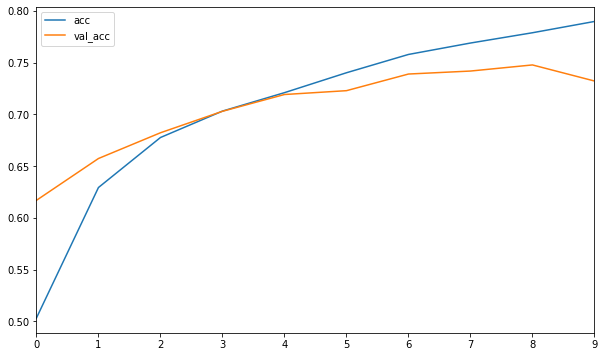

In [50]:
metrics_history = pd.DataFrame(history.history)
metrics_history[['loss', 'val_loss']].plot() #loss = train loss, val_loss = validation Loss
metrics_history[['acc', 'val_acc']].plot() # acc = train acc, val_acc = validation acc


In [122]:
y_val_pred = cnn_model.predict(X_val)

y_val_argmax = y_val.argmax(axis=1)
y_val_pred_argmax = y_val_pred.argmax(axis=1)

actual_val_activities = [reverse_activity_encoding[i] for i in y_val_argmax]
predicted_val_activities = [reverse_activity_encoding[i] for i in y_val_pred_argmax]

##### Below is Final Test Set results ######
y_test_pred = cnn_model.predict(X_test)
y_test_argmax = y_test.argmax(axis=1)
y_test_pred_argmax = y_test_pred.argmax(axis=1)
actual_test_activities = [reverse_activity_encoding[i] for i in y_test_argmax]
predicted_test_activities = [reverse_activity_encoding[i] for i in y_test_pred_argmax]

In [123]:
print("             Watch Results with CNN for Validation Set\n\n" + classification_report(predicted_val_activities,actual_val_activities))
print("             Watch Results with CNN for Test Set\n\n" + classification_report(predicted_test_activities,actual_test_activities))

             Watch Results with CNN for Validation Set

              precision    recall  f1-score   support

       catch       0.79      0.88      0.83       334
       chips       0.45      0.56      0.50       335
    clapping       0.91      0.89      0.90       420
   dribbling       0.88      0.90      0.89       387
    drinking       0.51      0.61      0.56       365
     folding       0.81      0.68      0.74       475
     jogging       0.97      0.97      0.97       397
     kicking       0.81      0.78      0.79       426
       pasta       0.62      0.60      0.61       411
    sandwich       0.44      0.42      0.43       428
     sitting       0.73      0.59      0.65       529
        soup       0.58      0.69      0.63       329
      stairs       0.83      0.74      0.78       391
    standing       0.68      0.76      0.72       360
       teeth       0.81      0.88      0.84       397
      typing       0.82      0.67      0.74       457
     walking       0.85  

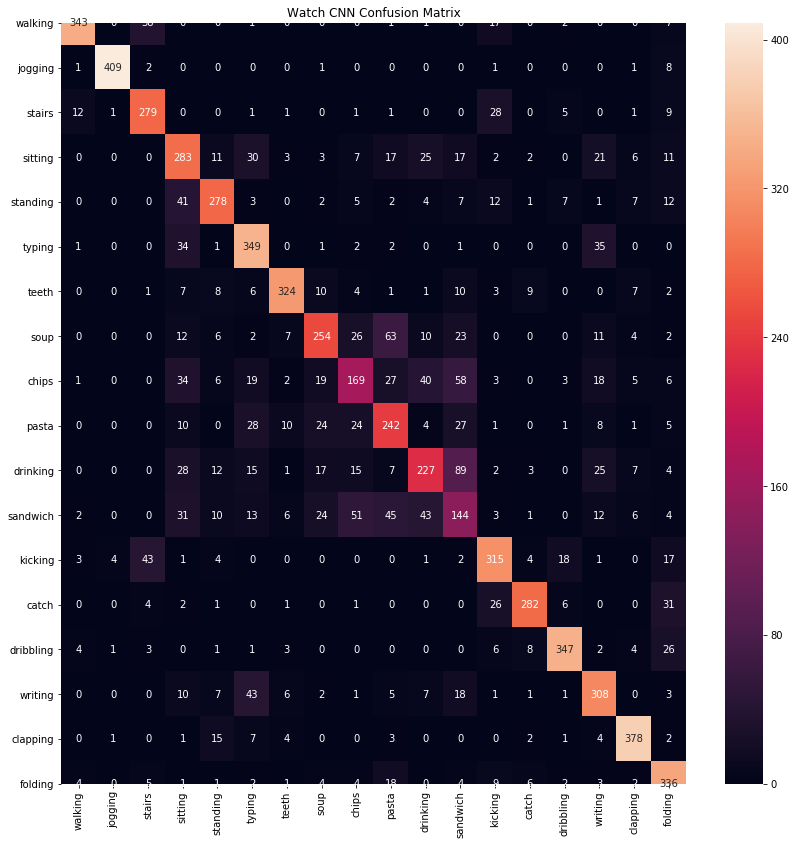

In [132]:
cm = confusion_matrix(y_test_argmax, y_test_pred_argmax)
df_cm = pd.DataFrame(cm, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (14,14))
plt.title('Watch CNN Confusion Matrix')
sn.heatmap(df_cm, annot=True, fmt='g')

# Training + Evaluating Stacked LSTM

In [84]:
lstm_model.compile(Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['acc'])

In [85]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = lstm_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=1)

lstm_model.summary()

Train on 21837 samples, validate on 7279 samples
Epoch 1/20
21837/21837 [==============================] - 45s 2ms/step - loss: 1.9788 - acc: 0.3609 - val_loss: 1.7221 - val_acc: 0.4389
Epoch 2/20
21837/21837 [==============================] - 45s 2ms/step - loss: 1.6041 - acc: 0.4743 - val_loss: 1.7084 - val_acc: 0.4620
Epoch 3/20
21837/21837 [==============================] - 46s 2ms/step - loss: 1.5185 - acc: 0.5101 - val_loss: 1.4754 - val_acc: 0.5297
Epoch 4/20
21837/21837 [==============================] - 44s 2ms/step - loss: 1.3910 - acc: 0.5474 - val_loss: 1.3365 - val_acc: 0.5681
Epoch 5/20
21837/21837 [==============================] - 44s 2ms/step - loss: 1.2478 - acc: 0.5808 - val_loss: 1.1993 - val_acc: 0.6016
Epoch 6/20
21837/21837 [==============================] - 45s 2ms/step - loss: 1.1583 - acc: 0.6097 - val_loss: 1.1486 - val_acc: 0.6195
Epoch 7/20
21837/21837 [==============================] - 43s 2ms/step - loss: 1.0779 - acc: 0.6362 - val_loss: 1.1403 - val_acc:

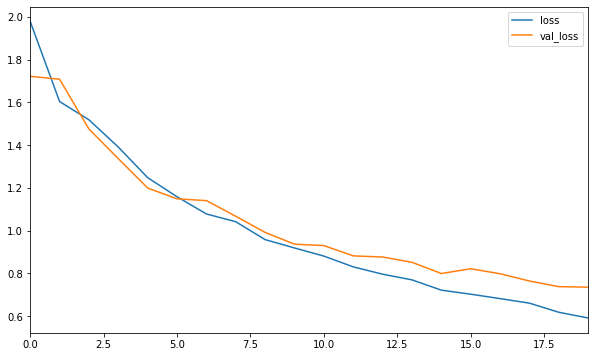

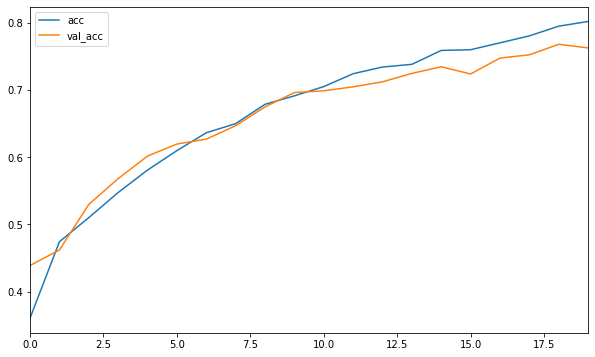

In [131]:
metrics_history = pd.DataFrame(history.history)

metrics_history[['loss', 'val_loss']].plot() #loss = train loss, val_loss = validation Loss
metrics_history[['acc', 'val_acc']].plot() # acc = train acc, val_acc = validation acc

In [119]:
lstm_y_val_pred = lstm_model.predict(X_val)

y_val_argmax = y_val.argmax(axis=1)
y_val_pred_argmax = lstm_y_val_pred.argmax(axis=1)

lstm_actual_val_activities = [reverse_activity_encoding[i] for i in y_val_argmax]
lstm_predicted_val_activities = [reverse_activity_encoding[i] for i in y_val_pred_argmax]

##### Below is Final Test Set results ######
lstm_y_test_pred = lstm_model.predict(X_test)
lstm_y_test_argmax = y_test.argmax(axis=1)

lstm_y_test_pred_argmax = lstm_y_test_pred.argmax(axis=1)

lstm_actual_test_activities = [reverse_activity_encoding[i] for i in lstm_y_test_argmax]
lstm_predicted_test_activities = [reverse_activity_encoding[i] for i in lstm_y_test_pred_argmax]

In [120]:
print("             Watch Results with LSTM for Validation Set\n\n" + classification_report(lstm_predicted_val_activities,lstm_actual_val_activities))
print("             Watch Results with LSTM for Test Set\n\n" + classification_report(lstm_predicted_test_activities,lstm_actual_test_activities))



             Watch Results with LSTM for Validation Set

              precision    recall  f1-score   support

       catch       0.88      0.93      0.91       349
       chips       0.60      0.56      0.58       449
    clapping       0.92      0.94      0.93       402
   dribbling       0.92      0.92      0.92       400
    drinking       0.55      0.69      0.61       353
     folding       0.88      0.79      0.83       449
     jogging       0.98      0.99      0.99       396
     kicking       0.81      0.86      0.84       388
       pasta       0.64      0.58      0.61       437
    sandwich       0.38      0.44      0.41       347
     sitting       0.65      0.67      0.66       415
        soup       0.69      0.65      0.67       414
      stairs       0.79      0.82      0.81       336
    standing       0.76      0.75      0.75       409
       teeth       0.82      0.93      0.87       379
      typing       0.76      0.67      0.71       423
     walking       0.92 

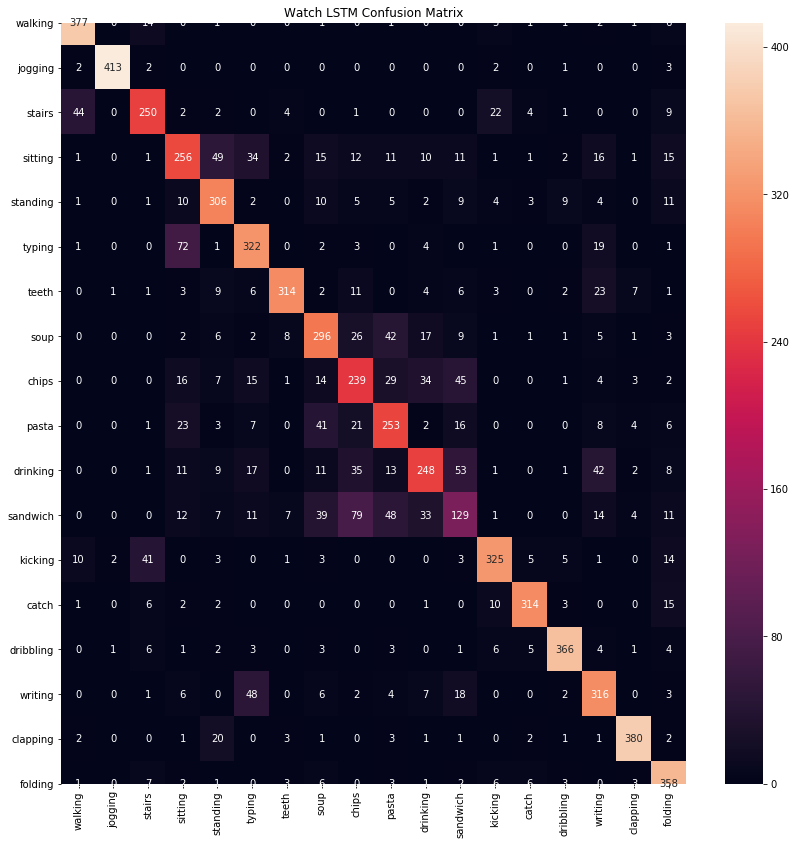

In [133]:
lstm_cm = confusion_matrix(lstm_y_test_argmax, lstm_y_test_pred_argmax)
df_cm = pd.DataFrame(lstm_cm, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (14,14))
plt.title('Watch LSTM Confusion Matrix')
sn.heatmap(df_cm, annot=True, fmt='g')